In [80]:
%config InlineBackend.figure_format = 'retina' # For high-resolution.
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch 
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam


import cv2
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

import segmentation_models_pytorch as smp


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

In [2]:
## Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.cuda.device_count())

RESOLUTION = 256
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = True

LEARNING_RATE = 1e-4
NUM_EPOCHS = 3

THRESHOLD = 0.3
# MIN_ACTIVATION_SIZE = 



cuda
1


## Create Dataframe, Dataset, Dataloader

In [63]:
def read_df(df_type):
    username = os.getcwd().split('/')[2]
    df_path = '/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format(username, df_type)
    df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path']]
    df['Mask_Path'] = df['Mask_Path'].str.replace('anw008', username)
    df['XRay_Path'] = df['XRay_Path'].str.replace('anw008', username)
    df['No_Pneumothorax'] = df['Mask_Path'].str.contains('negative_mask').astype(int)
    df['Yes_Pneumothorax'] = 1 - df['No_Pneumothorax']
    
    
    return df

In [64]:
train_df = read_df('train')
val_df = read_df('validation')
test_df = read_df('test')

In [65]:
val_df

,Mask_Path,XRay_Path,No_Pneumothorax,Yes_Pneumothorax
0,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0
1,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0
2,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0
3,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0
4,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,0,1
...,...,...,...,...
1915,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0
1916,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0
1917,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0
1918,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,/home/mel011/teams/dsc-180a---a14-[88137]/CAND...,1,0


In [66]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution, model_type):
        self.img_paths = df['XRay_Path'].values
        self.mask_paths = df['Mask_Path'].values
        self.labels = torch.tensor(df[['Yes_Pneumothorax', 'No_Pneumothorax']].values, dtype=torch.float32)
    
        self.resolution = resolution
        
        # model_type: 'C' for Classification, 'S' for Segmentation
        self.model_type = model_type
          
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = dicom.dcmread(img_path).pixel_array
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = (img - img_min) / (img_max - img_min)
        img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
        img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)
        
        if self.model_type == 'C':
            label = self.labels[idx]
            
            return img_norm, label
        
        elif self.model_type == 'S':
            mask_path = self.mask_paths[idx]
            mask = plt.imread(mask_path)[:, :, 0]
            mask = cv2.resize(mask, (self.resolution, self.resolution))
            mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 

            return img_norm, mask

In [84]:
### Create Dataset
train_ds = CANDID_PTX(train_df, RESOLUTION, 'C')
val_ds = CANDID_PTX(val_df, RESOLUTION, 'C')
test_ds = CANDID_PTX(test_df, RESOLUTION, 'C')

### Create Dataloader
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)


In [68]:
# ### Test dataloader
# sample = next(iter(val_loader))
# print("--Check length of first batch, should be 2")
# print(len(sample))
# print("--Check size of input images of first batch, should be ([{}, {}, {}, {}])".format(BATCH_SIZE, 3, RESOLUTION, RESOLUTION))
# print(sample[0].size())
# print(sample[0][0])
# print("--Check size of labels/masks of first batch")
# print(sample[1].size())
# print(sample[1][0])

## Train model

In [36]:
### Modifying model
class resnet34(nn.Module):

    """

    Best to use pre-trained

    """

    def __init__(self):

        super().__init__()

        self.model = models.resnet34(pretrained=True)

        # initialize new output layer

#         layers = np.array([layer for layer in self.model.children()])

#         for layer in layers[:-4]:

#             for param in layer.parameters():
                
#                 # Change parameters for all layers
#                 param.requires_grad = False
        
#         for layer in layers[-4][:-4]:
#             for param in layer.parameters():
#                 param.requires_grad = False
        
        layers = np.array([layer for layer in self.model.children()])
        
        for layer in layers[:-2]:

            for param in layer.parameters():
                
                # Change parameters for all layers
                param.requires_grad = False
                
        self.model.fc = nn.Linear(512, 2)
        
        #num_open_param = 0
        
#         for layer in layers[-3:]:
#             for param in layer.parameters():
#                 num_open_param += 1
#         print('Num Open Parameters: ', num_open_param)


    def forward(self, x):

        x = self.model(x)

        return x

In [37]:
model = resnet34()

In [38]:
def training(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader):
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
#     all_preds = []
#     all_masks = []
#     all_xray = []
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        model.train()
        
        for i, (imgs, labels) in enumerate(train_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            optimizer.zero_grad()
            preds = model(imgs)
            
            
            if (i == 0) & (epoch == 0):
                print(preds)
                print(labels)
#             print(preds.size())
#             print(masks.size())

            
            loss = loss_fn(preds, labels)
    
            loss.backward()
            optimizer.step()
            
            
#             with torch.cuda.amp.autocast():
#                 preds = model(imgs)
#                 if i == 0:
#                     all_preds.append(preds.detach().cpu())
#                 loss = loss_fn(preds, masks)
                        
#             optimizer.zero_grad()
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
            
            total_train_loss += float(loss)
            
            
        if epoch == 0:
            print("Total # of training batch: ", i + 1)

        all_train_loss.append(total_train_loss / batch_num)
            
            
    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()
        
        for i, (imgs, labels) in enumerate(val_loader):
            batch_num += 1
            
            imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
            
            preds = model(imgs)
            
            loss = loss_fn(preds, labels) # is this mean or sum?

            total_val_loss += float(loss) # accumulate the total loss for this epoch.
            
#             if i == 1:
#                 all_preds.append(preds.detach().cpu())
#                 all_masks.append(masks.detach().cpu())
#                 all_xray.append(imgs.detach().cpu())
            
        if epoch == 0:
            print("Total # of validation batch: ", i + 1)

        all_val_loss.append(total_val_loss / batch_num)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss#, all_preds, all_masks, all_xray

In [69]:
resnet_model, train_loss, val_loss = training(model = model,
                                            num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = train_loader, val_loader = val_loader)

  0%|          | 0/3 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([[-0.4904,  0.5116],
        [-0.5935,  0.9583],
        [ 0.2285, -0.2786],
        [ 0.4971, -0.7735]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]], device='cuda:0')
Total # of training batch:  1278


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of validation batch:  480


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [70]:
def plot_both_loss(all_train_loss, all_val_loss, model_name, resolution):
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    epoch_num = len(all_train_loss)
    df = pd.DataFrame({'x':range(epoch_num),
                    'train_loss':all_train_loss,
                      'val_loss':all_val_loss})
    df = df.set_index('x')
    
    train_val_loss = sns.lineplot(data=df, linewidth=2.5)

    ## now label the y- and x-axes.
    plt.ylabel('BCE Loss')
    plt.xlabel('Epoch Number')
    plt.title('BCE Loss of {} with resolution {}'.format(model_name, resolution))
    plt.show()
    
    fig = train_val_loss.get_figure()
    #fig.save('train_val_loss.png')

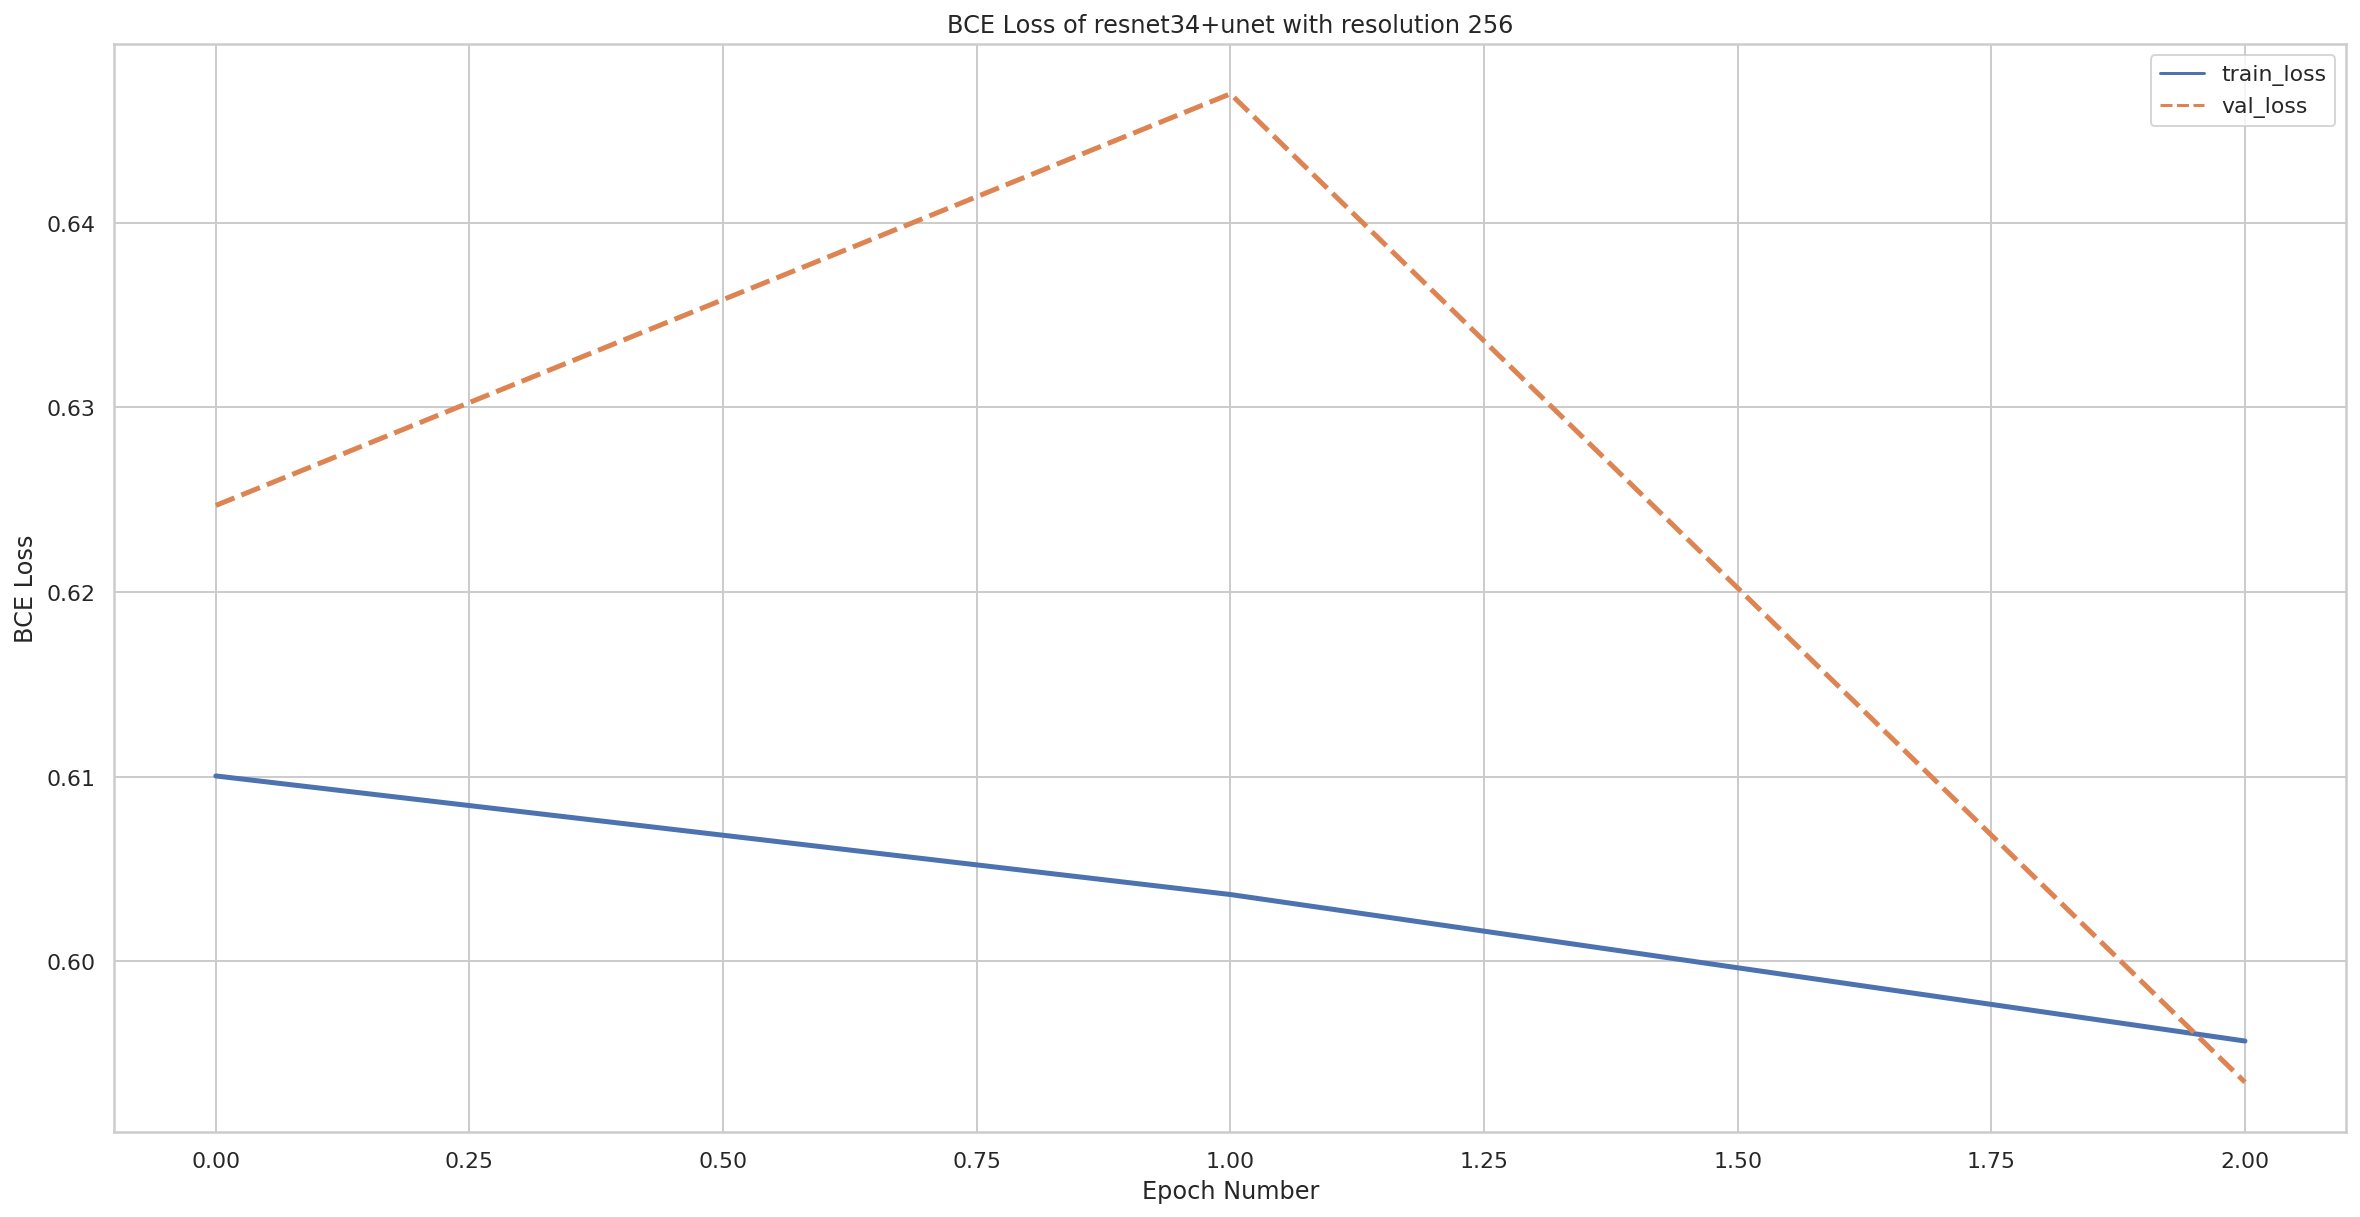

In [71]:
plot_both_loss(train_loss, val_loss, 'resnet34+unet', str(RESOLUTION))

## Test Metrics

In [81]:
def plot_confusion_matrix(y_test, y_true, model_name, resolution):
    
    cm = confusion_matrix(y_true, y_test)

    sns.heatmap(cm, annot=True, cmap = 'Blues', fmt="d")
    plt.title('Confusion matrix of model {} with resolution {}'.format(model_name, resolution))
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

In [89]:
def plot_roc_curve(y_test, y_true, model_name, resolution):
    fpr, tpr, threshold = roc_curve(y_true, y_test, drop_intermediate = False)
    roc_auc = roc_auc_score(y_true, y_test)

    plt.figure(1)
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_name, roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve of model {} with resolution {}'.format(model_name, resolution))
    plt.legend(loc='best')
    plt.show()

In [105]:
def test_metrics(test_loader, model):
    """
    Calculate confusion matrix & auc-roc
    Return a list 
    """
    y_test = np.array([])
    y_true = np.array([])
    total_num_batch = 0
    for i, (imgs, labels) in enumerate(test_loader):
        total_num_batch += 1
        imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
        preds = model(imgs)
        
        soft_max = nn.Softmax(dim=1)
        pred_prob = soft_max(preds).detach().cpu().numpy()
        
        pred_label = np.argmax(pred_prob, axis=1)
        true_label = labels.detach().cpu().numpy().astype(int)[:, 1]
        
        y_test = np.concatenate((y_test, pred_label))
        y_true = np.concatenate((y_true, true_label))
    
    plot_confusion_matrix(y_test, y_true, 'resnet34', '256x256')
    plot_roc_curve(y_test, y_true, 'resnet34', '256x256')
    
    print('Total Number of Batch Size: ', total_num_batch)
    return y_test, y_true

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[1. 0. 0. ... 1. 1. 0.]
[1. 1. 1. ... 1. 1. 0.]


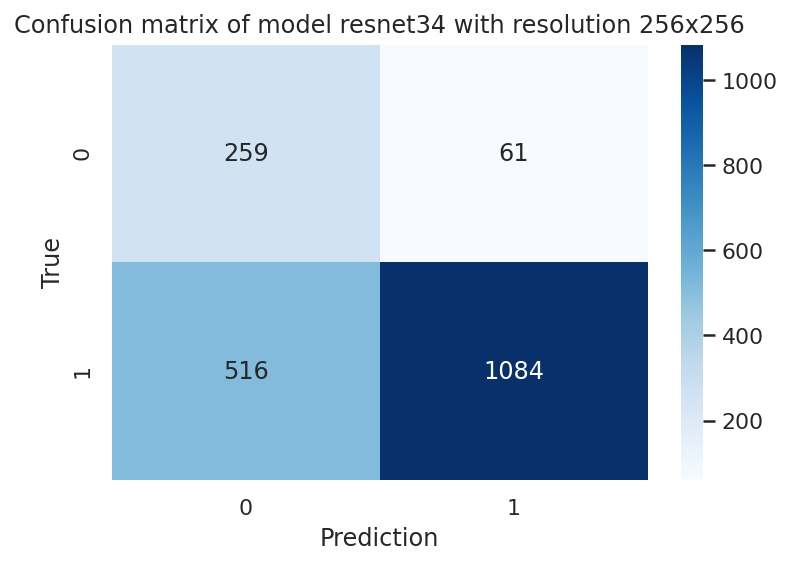

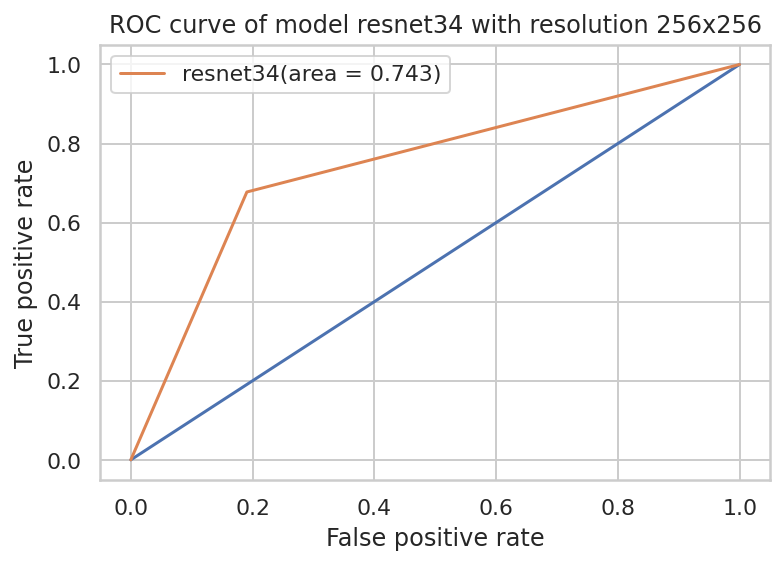

Total Number of Batch Size:  480


In [106]:
y_test, y_true = test_metrics(test_loader, resnet_model)